In [408]:
#!pip install numba yfinance pandas datetime cudf numba

In [409]:
#!pip install cudf

In [410]:
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import datetime
from datetime import timedelta
from datetime import date

import cupy as cp

In [411]:
import numpy as np

import numba
from numba import cuda

@numba.jit(nopython=True)
def compute_bin(x, n, xmin, xmax):
    # special case to mirror NumPy behavior for last bin
    if x == xmax:
        return n - 1 # a_max always in last bin

    # SPEEDTIP: Remove the float64 casts if you don't need to exactly reproduce NumPy
    bin = np.int32(n * (np.float64(x) - np.float64(xmin)) / (np.float64(xmax) - np.float64(xmin)))

    if bin < 0 or bin >= n:
        return None
    else:
        return bin

@cuda.jit
def histogram(x, xmin, xmax, histogram_out):
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins

    start = cuda.grid(1)
    stride = cuda.gridsize(1)

    for i in range(start, x.shape[0], stride):
        # note that calling a numba.jit function from CUDA automatically
        # compiles an equivalent CUDA device function!
        bin_number = compute_bin(x[i], nbins, xmin, xmax)

        if bin_number >= 0 and bin_number < histogram_out.shape[0]:
            cuda.atomic.add(histogram_out, bin_number, 1)

@cuda.jit
def min_max(x, min_max_array):
    nelements = x.shape[0]

    start = cuda.grid(1)
    stride = cuda.gridsize(1)

    # Array already seeded with starting values appropriate for x's dtype
    # Not a problem if this array has already been updated
    local_min = min_max_array[0]
    local_max = min_max_array[1]

    for i in range(start, x.shape[0], stride):
        element = x[i]
        local_min = min(element, local_min)
        local_max = max(element, local_max)

    # Now combine each thread local min and max
    cuda.atomic.min(min_max_array, 0, local_min)
    cuda.atomic.max(min_max_array, 1, local_max)


def dtype_min_max(dtype):
    '''Get the min and max value for a numeric dtype'''
    if np.issubdtype(dtype, np.integer):
        info = np.iinfo(dtype)
    else:
        info = np.finfo(dtype)
    return info.min, info.max


@numba.jit(nopython=True)
def get_bin_edges(a, nbins, a_min, a_max):
    bin_edges = np.empty((nbins+1,), dtype=np.float64)
    delta = (a_max - a_min) / nbins
    for i in range(bin_edges.shape[0]):
        bin_edges[i] = a_min + i * delta

    bin_edges[-1] = a_max  # Avoid roundoff error on last point
    return bin_edges


def numba_gpu_histogram(a, bins):
    # Move data to GPU so we can do two operations on it
    a_gpu = cuda.to_device(a)

    ### Find min and max value in array
    dtype_min, dtype_max = dtype_min_max(a.dtype)
    # Put them in the array in reverse order so that they will be replaced by the first element in the array
    min_max_array_gpu = cuda.to_device(np.array([dtype_max, dtype_min], dtype=a.dtype))
    min_max[64, 64](a_gpu, min_max_array_gpu)
    a_min, a_max = min_max_array_gpu.copy_to_host()

    # SPEEDTIP: Skip this step if you don't need to reproduce the NumPy histogram edge array
    bin_edges = get_bin_edges(a, bins, a_min, a_max) # Doing this on CPU for now

    ### Bin the data into a histogram 
    histogram_out = cuda.to_device(np.zeros(shape=(bins,), dtype=np.int32))
    histogram[64, 64](a_gpu, a_min, a_max, histogram_out)

    return histogram_out.copy_to_host(), bin_edges

In [412]:


n_forward = 7
name = 'BTC-USD'
#name = 'GLD'
#name = 'SPY'
#name = 'GOOG'

#strategy = "EMA"
strategy = "SMA"
#indicator = 'Close'
indicator = 'VWP'

w=117
end_date = datetime.date.today()
#end_date = datetime.date.today() - timedelta(weeks=w)
end_date1 = end_date - timedelta(weeks=w)
start_date = end_date1 - timedelta(weeks=w)

benchName = "^GSPC"
bench = yfinance.Ticker(benchName)
#bench Data needs to be +1 because it ends the day before end_date

benchData = bench.history(interval="1d",start=start_date,end=end_date+timedelta(days=1), auto_adjust=True)

In [413]:
calc_returns = cp.ElementwiseKernel(
   'float32 x, float32 y',
   'float32 z',
   'z = (x - y) / y',
   'calc_returns')

In [416]:
returns = cp.ndarray.get(calc_returns(cp.array(benchData['Close'],dtype=np.float32),cp.array(benchData['Close'].shift(+1),dtype=np.float32)))

(array([[ 66.,   8.,   5.,   2.,   2.,   0.,   2.,   1.,   2.,   0.,   1.,
           0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
           0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
           1.],
        [101.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         

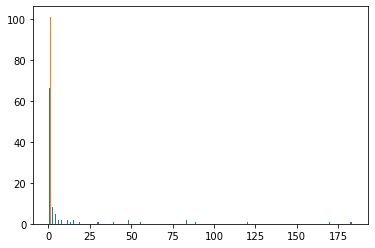

In [419]:


b = 100
plt.hist(numba_gpu_histogram(returns,b), bins=b)  # arguments are passed to np.histogram